In [2]:
# --- Load tar-based sample_csv data for histogram and gamma analysis ---
from pathlib import Path
import tarfile
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if "apply_plot_style" not in globals():
    def apply_plot_style():
        plt.style.use("seaborn-v0_8-whitegrid")
        plt.rcParams.update({
            "figure.dpi": 130,
            "savefig.dpi": 300,
            "axes.titlesize": 13,
            "axes.titleweight": "semibold",
            "axes.labelsize": 12,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "grid.alpha": 0.28,
            "grid.linestyle": "--",
            "legend.frameon": True,
            "legend.framealpha": 0.9,
            "legend.fancybox": True,
            "legend.edgecolor": "0.8",
            "mathtext.fontset": "stix",
            "font.family": "STIXGeneral",
        })

apply_plot_style()

try:
    from IPython.display import display
except Exception:
    def display(obj):
        print(obj)

ROOT_CANDIDATES = [
    Path('/home/bh692/scratch_pi_co54/bh692/results/20260113_test_area_with_num_tri_types'),
    Path('../results/20260113_test_area_with_num_tri_types'),
    Path('results/20260113_test_area_with_num_tri_types'),
]
run_root = next((p for p in ROOT_CANDIDATES if p.exists()), ROOT_CANDIDATES[0])
if not run_root.exists():
    raise RuntimeError(f'Results directory not found. Tried: {ROOT_CANDIDATES}')

print(f'Using run root: {run_root}')


def parse_t_label(path: Path):
    # T_0.8.tar -> (0.8, '0.8')
    label = path.stem.split('_', 1)[1]
    return float(label), label


def parse_kv_numeric(line: str):
    tokens = [tok.strip() for tok in line.split(',') if tok.strip() != '']
    if len(tokens) % 2 != 0:
        return {}
    out = {}
    for key, value in zip(tokens[::2], tokens[1::2]):
        try:
            out[key] = float(value)
        except ValueError:
            out[key] = np.nan
    return out


def extract_member(tf: tarfile.TarFile, candidates):
    for name in candidates:
        try:
            f = tf.extractfile(name)
            if f is not None:
                return f
        except KeyError:
            continue
    return None


lambda_values = np.round(np.arange(0.0, 1.0000001, 0.025), 6)
lambda_labels = [f'{v:.6f}' for v in lambda_values]
STEP_MIN = int(globals().get('min_step_count', 100000))

tar_paths = sorted(run_root.glob('T_*.tar'), key=lambda p: parse_t_label(p)[0])
if not tar_paths:
    raise RuntimeError(f'No T_*.tar files found in: {run_root}')

print(f'Found {len(tar_paths)} tar files.')
print(f'Using only rows with step > {STEP_MIN}')


group_arrays = {}
group_rows = []
gamma_fit_rows = []

for tar_path in tar_paths:
    T_value, t_label = parse_t_label(tar_path)
    print(f'Loading T={T_value:g} from {tar_path.name} ...')

    with tarfile.open(tar_path, 'r') as tf:
        for lam_label in lambda_labels:
            lam_value = float(lam_label)
            base_a = f'./T_{t_label}/lambda_{lam_label}/sample_csv/'
            base_b = f'T_{t_label}/lambda_{lam_label}/sample_csv/'

            cwa_file = extract_member(tf, [base_a + 'cwa_instant.csv', base_b + 'cwa_instant.csv'])
            if cwa_file is None:
                continue

            gamma_vals = []
            c0_vals = []
            ly_vals = []

            q2_map = {}
            cq_sum = defaultdict(float)
            cq_count = defaultdict(int)

            for raw in cwa_file:
                line = raw.decode('utf-8', 'ignore').strip()
                if not line:
                    continue
                d = parse_kv_numeric(line)
                if not d:
                    continue

                step = d.get('step', np.nan)
                if not np.isfinite(step) or step <= STEP_MIN:
                    continue

                g = d.get('gamma', np.nan)
                c0 = d.get('C0', np.nan)
                ly = d.get('Ly', np.nan)

                if np.isfinite(g):
                    gamma_vals.append(g)
                if np.isfinite(c0):
                    c0_vals.append(c0)
                if np.isfinite(ly):
                    ly_vals.append(ly)

                for key, q2 in d.items():
                    if not key.startswith('q_sq_') or not np.isfinite(q2):
                        continue
                    mode = int(key.split('_')[-1])
                    q2_map[mode] = q2

                    cq_key = f'Cq_{mode}'
                    cq_val = d.get(cq_key, np.nan)
                    if np.isfinite(cq_val):
                        cq_sum[mode] += cq_val
                        cq_count[mode] += 1

            gamma_vals = np.asarray(gamma_vals, dtype=float)
            if gamma_vals.size == 0:
                continue

            fit_modes = sorted([m for m in q2_map if cq_count.get(m, 0) > 0])
            gamma_fit = np.nan
            c0_fit = np.nan
            if len(fit_modes) >= 2:
                x = np.array([q2_map[m] for m in fit_modes], dtype=float)
                y = np.array([cq_sum[m] / cq_count[m] for m in fit_modes], dtype=float)
                good = np.isfinite(x) & np.isfinite(y)
                if np.count_nonzero(good) >= 2:
                    gamma_fit, c0_fit = np.polyfit(x[good], y[good], 1)

            # AB pair length log
            ab_file = extract_member(tf, [base_a + 'ab_pair_length_log.csv', base_b + 'ab_pair_length_log.csv'])
            ab_steps = []
            ab_vals = []
            if ab_file is not None:
                for raw in ab_file:
                    line = raw.decode('utf-8', 'ignore').strip()
                    if not line or line.lower().startswith('step,ab_pair_length'):
                        continue
                    d = parse_kv_numeric(line)
                    step = d.get('step', np.nan)
                    val = d.get('AB_pair_length', np.nan)
                    if np.isfinite(step) and step > STEP_MIN and np.isfinite(val):
                        ab_steps.append(int(step))
                        ab_vals.append(val)
            ab_steps = np.asarray(ab_steps, dtype=int)
            ab_vals = np.asarray(ab_vals, dtype=float)

            # U/K total log (for partial_U_lambda / L_AB)
            u_file = extract_member(tf, [base_a + 'U_K_tot_log.csv', base_b + 'U_K_tot_log.csv'])
            u_steps = []
            partial_u_vals = []
            ly_u_vals = []
            if u_file is not None:
                for raw in u_file:
                    line = raw.decode('utf-8', 'ignore').strip()
                    if not line:
                        continue
                    d = parse_kv_numeric(line)
                    step = d.get('step', np.nan)
                    if not np.isfinite(step) or step <= STEP_MIN:
                        continue
                    pu = d.get('partial_U_lambda', np.nan)
                    ly_u = d.get('Ly', np.nan)
                    if np.isfinite(pu):
                        u_steps.append(int(step))
                        partial_u_vals.append(pu)
                    if np.isfinite(ly_u):
                        ly_u_vals.append(ly_u)
            u_steps = np.asarray(u_steps, dtype=int)
            partial_u_vals = np.asarray(partial_u_vals, dtype=float)

            # Triangulation counts -> mixed fraction
            tri_file = extract_member(tf, [base_a + 'triangulation_types_log.csv', base_b + 'triangulation_types_log.csv'])
            mix_vals = []
            if tri_file is not None:
                for raw in tri_file:
                    line = raw.decode('utf-8', 'ignore').strip()
                    if not line or line.lower().startswith('step,aaa'):
                        continue
                    d = parse_kv_numeric(line)
                    step = d.get('step', np.nan)
                    if not np.isfinite(step) or step <= STEP_MIN:
                        continue
                    aaa = d.get('AAA', np.nan)
                    aab = d.get('AAB', np.nan)
                    abb = d.get('ABB', np.nan)
                    bbb = d.get('BBB', np.nan)
                    total = aaa + aab + abb + bbb
                    if np.isfinite(total) and total > 0 and np.isfinite(aab) and np.isfinite(abb):
                        mix_vals.append((aab + abb) / total)
            mix_vals = np.asarray(mix_vals, dtype=float)

            # Ly: prefer CWA Ly, fallback to U log Ly
            ly_all = np.asarray(list(ly_vals) + list(ly_u_vals), dtype=float)
            ly_ref = float(np.nanmedian(ly_all)) if ly_all.size > 0 else np.nan

            # Derived line-tension-like estimator
            u_over_ab = np.array([], dtype=float)
            if ab_steps.size > 0 and u_steps.size > 0:
                ab_map = {int(s): float(v) for s, v in zip(ab_steps, ab_vals)}
                proxy = []
                for s, pu in zip(u_steps, partial_u_vals):
                    L = ab_map.get(int(s))
                    if L is None or not np.isfinite(L) or L <= 0:
                        continue
                    proxy.append(pu / L)
                if proxy:
                    u_over_ab = np.asarray(proxy, dtype=float)

            ab_over_ly = np.array([], dtype=float)
            if ab_vals.size > 0 and np.isfinite(ly_ref) and ly_ref > 0:
                ab_over_ly = ab_vals / ly_ref

            group_key = (T_value, lam_value)
            group_arrays[group_key] = {
                'gamma': gamma_vals,
                'c0': np.asarray(c0_vals, dtype=float),
                'ab_length': ab_vals,
                'ab_over_ly': ab_over_ly,
                'mix_fraction': mix_vals,
                'u_over_ab': u_over_ab,
                'Ly': np.asarray([ly_ref], dtype=float),
            }

            group_rows.append({
                'T': T_value,
                'lambda': lam_value,
                'n_gamma': int(gamma_vals.size),
                'gamma_mean': float(np.mean(gamma_vals)),
                'gamma_std': float(np.std(gamma_vals, ddof=1)) if gamma_vals.size > 1 else np.nan,
                'ab_over_ly_mean': float(np.mean(ab_over_ly)) if ab_over_ly.size > 0 else np.nan,
                'mix_fraction_mean': float(np.mean(mix_vals)) if mix_vals.size > 0 else np.nan,
                'u_over_ab_mean': float(np.mean(u_over_ab)) if u_over_ab.size > 0 else np.nan,
                'Ly': ly_ref,
            })

            gamma_fit_rows.append({
                'T': T_value,
                'lambda': lam_value,
                'gamma_fit_from_avg_Cq': gamma_fit,
                'C0_fit_from_avg_Cq': c0_fit,
                'n_modes_fit': len(fit_modes),
            })

if not group_rows:
    raise RuntimeError('No sample_csv data were loaded. Check run_root and tar contents.')

group_stats_df = pd.DataFrame(group_rows).sort_values(['T', 'lambda']).reset_index(drop=True)
gamma_fit_df = pd.DataFrame(gamma_fit_rows).sort_values(['T', 'lambda']).reset_index(drop=True)

print(f'Loaded groups: {len(group_stats_df)}')
print(f'Unique T: {sorted(group_stats_df["T"].unique())}')
print(f'Lambda count per T (median): {int(group_stats_df.groupby("T")["lambda"].count().median())}')

display(group_stats_df.head(12))


Using run root: /home/bh692/scratch_pi_co54/bh692/results/20260113_test_area_with_num_tri_types
Found 6 tar files.
Using only rows with step > 100000
Loading T=0.5 from T_0.5.tar ...
Loading T=0.6 from T_0.6.tar ...
Loading T=0.7 from T_0.7.tar ...
Loading T=0.8 from T_0.8.tar ...
Loading T=0.9 from T_0.9.tar ...
Loading T=1 from T_1.0.tar ...
Loaded groups: 246
Unique T: [np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9), np.float64(1.0)]
Lambda count per T (median): 41


,T,lambda,n_gamma,gamma_mean,gamma_std,ab_over_ly_mean,mix_fraction_mean,u_over_ab_mean,Ly
0,0.5,0.000,3891,0.888875,1.100713,3.243925,0.005011,-0.054594,106.666667
1,0.5,0.025,3858,0.664965,0.785064,3.197053,0.004918,-0.007709,106.267416
2,0.5,0.050,3883,0.905012,2.194344,3.131579,0.004809,-0.023780,105.869660
3,0.5,0.075,3523,0.754932,1.495386,3.080086,0.004715,-0.021779,105.473392
4,0.5,0.100,3772,0.989050,1.046171,3.124814,0.004729,-0.072519,105.078607
5,0.5,0.125,3995,0.841060,1.236022,3.178295,0.004802,-0.024694,104.685300
6,0.5,0.150,3781,0.692279,1.270010,3.133059,0.004735,-0.031098,104.293466
7,0.5,0.175,3935,1.023870,2.529358,3.201061,0.004813,-0.011066,103.903098
8,0.5,0.200,3832,0.993656,1.253317,3.241119,0.004854,-0.053335,103.514191
9,0.5,0.225,3826,0.703617,1.086764,3.248639,0.004846,-0.042389,103.126739


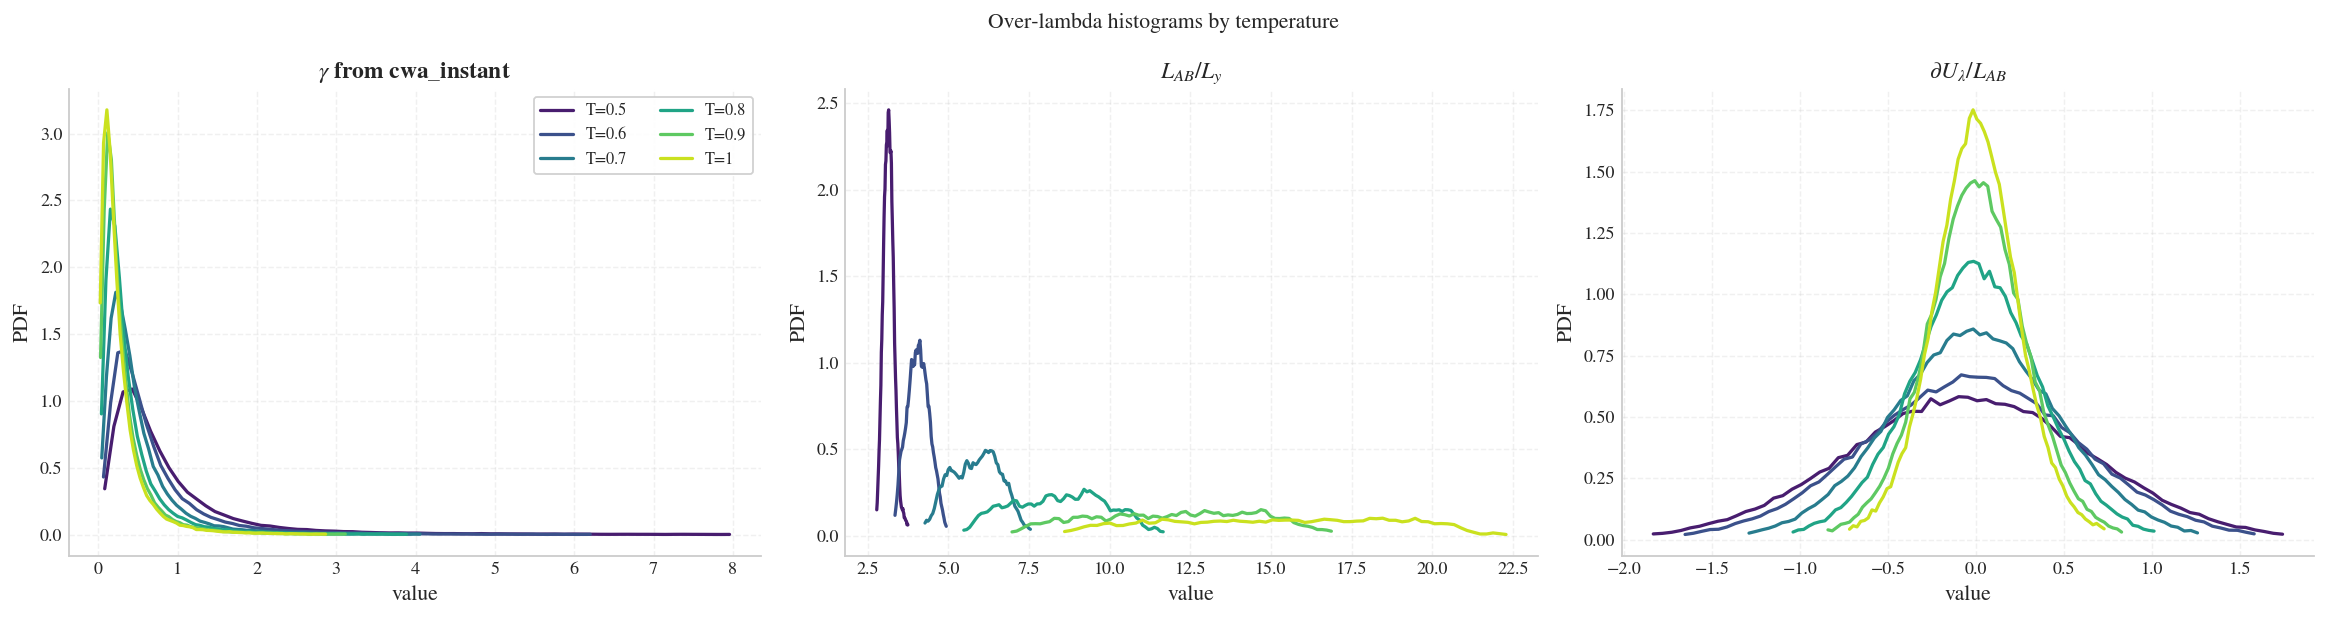

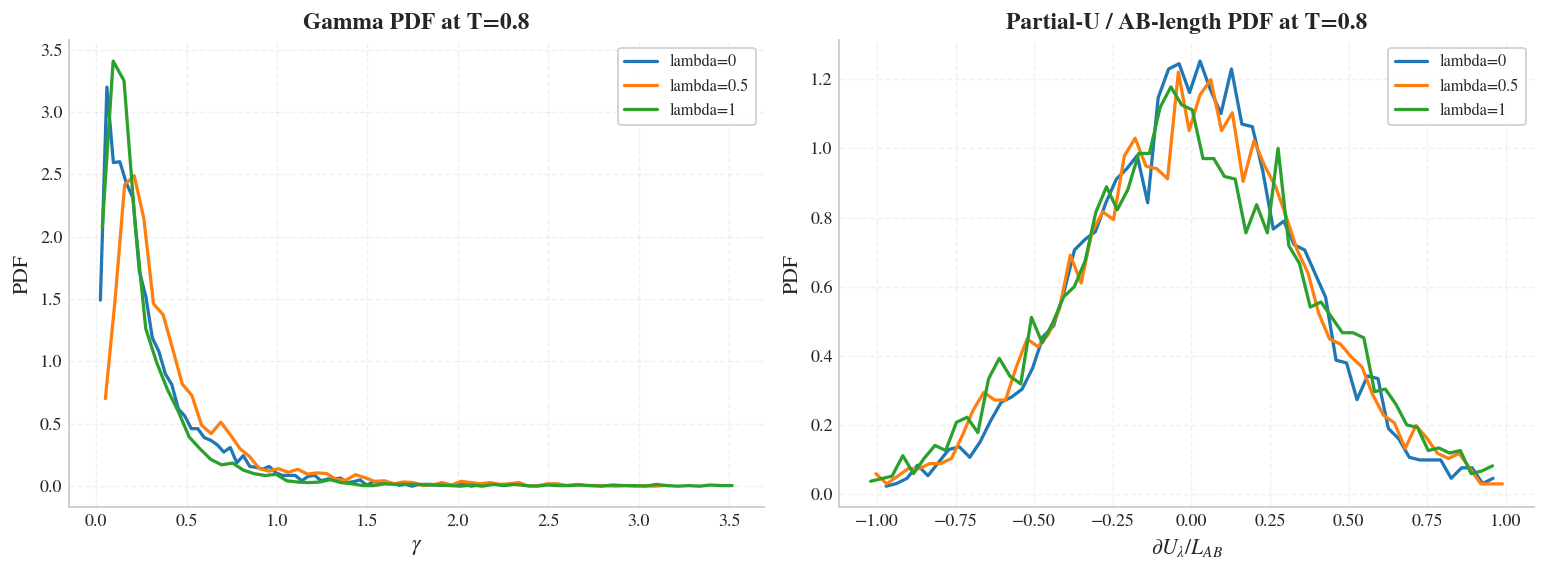

In [3]:
# --- Histogram plots for line-tension-related observables ---
import numpy as np
import matplotlib.pyplot as plt

if 'group_arrays' not in globals() or 'group_stats_df' not in globals():
    raise RuntimeError('Run the first cell first to build group_arrays and group_stats_df.')


def collect_metric(metric_key, T=None, lam=None):
    chunks = []
    for (t_val, lam_val), vals in group_arrays.items():
        if T is not None and float(t_val) != float(T):
            continue
        if lam is not None and abs(float(lam_val) - float(lam)) > 1e-12:
            continue
        arr = np.asarray(vals.get(metric_key, []), dtype=float)
        arr = arr[np.isfinite(arr)]
        if arr.size > 0:
            chunks.append(arr)
    if not chunks:
        return np.array([], dtype=float)
    return np.concatenate(chunks)


all_T = sorted(group_stats_df['T'].unique())
colors = plt.cm.viridis(np.linspace(0.08, 0.92, len(all_T)))
metric_specs = [
    ('gamma', r'$\gamma$ from cwa_instant', 0.5, 99.5),
    ('ab_over_ly', r'$L_{AB}/L_y$', 0.5, 99.5),
    ('u_over_ab', r'$\partial U_\lambda / L_{AB}$', 0.5, 99.5),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 4.8))
for ax, (metric_key, title, q_lo, q_hi) in zip(axes, metric_specs):
    for color, T in zip(colors, all_T):
        data = collect_metric(metric_key, T=T)
        if data.size < 25:
            continue
        lo, hi = np.percentile(data, [q_lo, q_hi])
        sel = data[(data >= lo) & (data <= hi)]
        if sel.size < 20:
            continue
        bins = np.linspace(lo, hi, 70)
        hist, edges = np.histogram(sel, bins=bins, density=True)
        centers = 0.5 * (edges[:-1] + edges[1:])
        ax.plot(centers, hist, lw=1.8, color=color, label=f'T={T:g}')

    ax.set_title(title)
    ax.set_xlabel('value')
    ax.set_ylabel('PDF')
    ax.grid(True, alpha=0.28, ls='--')

axes[0].legend(ncol=2, fontsize=9)
fig.suptitle('Over-lambda histograms by temperature')
fig.tight_layout()
plt.show()


# Extra view: for one T, compare lambda dependence directly
if 0.8 in all_T:
    T_ref = 0.8
else:
    T_ref = all_T[len(all_T) // 2]

selected_lambdas = [0.0, 0.5, 1.0]
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
for lam in selected_lambdas:
    g = collect_metric('gamma', T=T_ref, lam=lam)
    u = collect_metric('u_over_ab', T=T_ref, lam=lam)

    if g.size > 20:
        lo, hi = np.percentile(g, [0.5, 99.5])
        bins = np.linspace(lo, hi, 60)
        hist, edges = np.histogram(g[(g >= lo) & (g <= hi)], bins=bins, density=True)
        centers = 0.5 * (edges[:-1] + edges[1:])
        axes[0].plot(centers, hist, lw=1.8, label=f'lambda={lam:g}')

    if u.size > 20:
        lo, hi = np.percentile(u, [0.5, 99.5])
        bins = np.linspace(lo, hi, 60)
        hist, edges = np.histogram(u[(u >= lo) & (u <= hi)], bins=bins, density=True)
        centers = 0.5 * (edges[:-1] + edges[1:])
        axes[1].plot(centers, hist, lw=1.8, label=f'lambda={lam:g}')

axes[0].set_title(fr'Gamma PDF at T={T_ref:g}')
axes[0].set_xlabel(r'$\gamma$')
axes[0].set_ylabel('PDF')
axes[1].set_title(fr'Partial-U / AB-length PDF at T={T_ref:g}')
axes[1].set_xlabel(r'$\partial U_\lambda / L_{AB}$')
axes[1].set_ylabel('PDF')
for ax in axes:
    ax.grid(True, alpha=0.28, ls='--')
    ax.legend(fontsize=9)
fig.tight_layout()
plt.show()


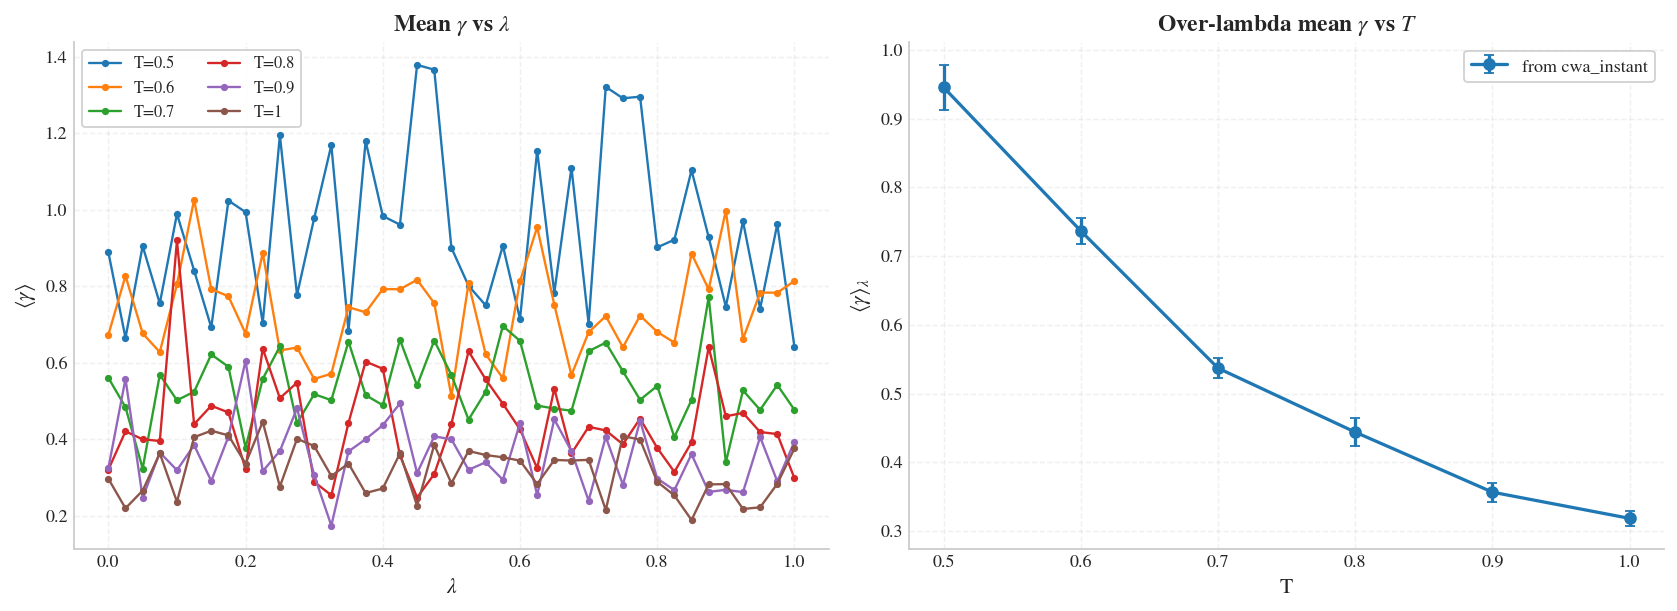

Per-T gamma summary (from cwa_instant):


,T,gamma_mean_over_lambda,gamma_std_over_lambda,gamma_sem_over_lambda,proxy_mean_over_lambda,n_lambda
0,0.5,0.945628,0.209345,0.032694,-0.043677,41
1,0.6,0.736630,0.117659,0.018375,-0.025157,41
2,0.7,0.536927,0.094614,0.014776,-0.011704,41
3,0.8,0.443806,0.127919,0.019978,-0.007137,41
4,0.9,0.356451,0.089424,0.013966,-0.002373,41
5,1.0,0.318304,0.067686,0.010571,-0.000699,41


Comparison with analysis_data/data.csv:


,T,gamma_mean_over_lambda,gamma_std_over_lambda,gamma_sem_over_lambda,proxy_mean_over_lambda,n_lambda,cwa_mean_over_lambda,gamma_micro_U_vs_AB_length
0,0.5,0.945628,0.209345,0.032694,-0.043677,41,0.455362,0.602567
1,0.6,0.736630,0.117659,0.018375,-0.025157,41,0.361376,0.791655
2,0.7,0.536927,0.094614,0.014776,-0.011704,41,0.272320,0.781163
3,0.8,0.443806,0.127919,0.019978,-0.007137,41,0.198108,0.865061
4,0.9,0.356451,0.089424,0.013966,-0.002373,41,0.155233,0.865555
5,1.0,0.318304,0.067686,0.010571,-0.000699,41,0.137101,0.869309


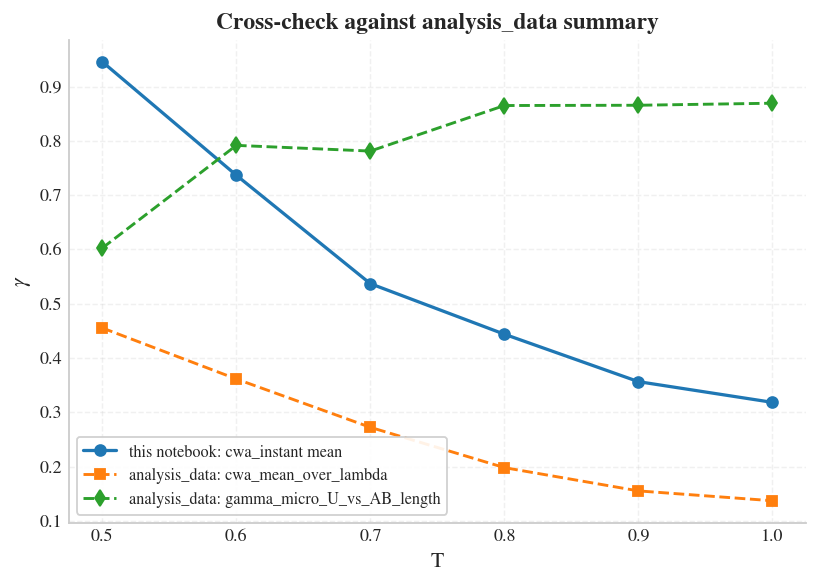

In [4]:
# --- Gamma analysis: vs lambda and vs temperature ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if 'group_stats_df' not in globals() or 'run_root' not in globals():
    raise RuntimeError('Run the first cell first to build group_stats_df.')

plot_df = group_stats_df.copy()
plot_df = plot_df[np.isfinite(plot_df['gamma_mean'])].copy()

fig, axes = plt.subplots(1, 2, figsize=(13, 4.8))

# gamma(lambda) for each T
for T, sub in plot_df.groupby('T'):
    sub = sub.sort_values('lambda')
    axes[0].plot(sub['lambda'], sub['gamma_mean'], marker='o', ms=3, lw=1.3, label=f'T={T:g}')

axes[0].set_title(r'Mean $\gamma$ vs $\lambda$')
axes[0].set_xlabel(r'$\lambda$')
axes[0].set_ylabel(r'$\langle \gamma \rangle$')
axes[0].grid(True, alpha=0.28, ls='--')
axes[0].legend(ncol=2, fontsize=9)

# over-lambda average by T
def sem_of_mean(x):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size <= 1:
        return np.nan
    return float(np.std(x, ddof=1) / np.sqrt(x.size))

summary_T = (
    plot_df.groupby('T')
    .agg(
        gamma_mean_over_lambda=('gamma_mean', 'mean'),
        gamma_std_over_lambda=('gamma_mean', 'std'),
        gamma_sem_over_lambda=('gamma_mean', sem_of_mean),
        proxy_mean_over_lambda=('u_over_ab_mean', 'mean'),
        n_lambda=('lambda', 'count'),
    )
    .reset_index()
    .sort_values('T')
)

axes[1].errorbar(
    summary_T['T'],
    summary_T['gamma_mean_over_lambda'],
    yerr=summary_T['gamma_sem_over_lambda'],
    marker='o',
    lw=1.8,
    capsize=3,
    label='from cwa_instant',
)
axes[1].set_title(r'Over-lambda mean $\gamma$ vs $T$')
axes[1].set_xlabel('T')
axes[1].set_ylabel(r'$\langle \gamma \rangle_\lambda$')
axes[1].grid(True, alpha=0.28, ls='--')
axes[1].legend()

fig.tight_layout()
plt.show()

print('Per-T gamma summary (from cwa_instant):')
display(summary_T)

# Compare with existing analysis_data/data.csv when available
analysis_csv = run_root / 'analysis_data' / 'data.csv'
if analysis_csv.exists():
    ref_df = pd.read_csv(analysis_csv, skipinitialspace=True)
    ref_df.columns = [c.strip() for c in ref_df.columns]

    keep_cols = [c for c in ['T', 'cwa_mean_over_lambda', 'gamma_micro_U_vs_AB_length'] if c in ref_df.columns]
    cmp_df = summary_T.merge(ref_df[keep_cols], on='T', how='left')

    print('Comparison with analysis_data/data.csv:')
    display(cmp_df)

    fig, ax = plt.subplots(figsize=(6.4, 4.6))
    ax.plot(cmp_df['T'], cmp_df['gamma_mean_over_lambda'], 'o-', lw=1.8, label='this notebook: cwa_instant mean')
    if 'cwa_mean_over_lambda' in cmp_df:
        ax.plot(cmp_df['T'], cmp_df['cwa_mean_over_lambda'], 's--', lw=1.6, label='analysis_data: cwa_mean_over_lambda')
    if 'gamma_micro_U_vs_AB_length' in cmp_df:
        ax.plot(cmp_df['T'], cmp_df['gamma_micro_U_vs_AB_length'], 'd--', lw=1.6, label='analysis_data: gamma_micro_U_vs_AB_length')
    ax.set_xlabel('T')
    ax.set_ylabel(r'$\gamma$')
    ax.set_title('Cross-check against analysis_data summary')
    ax.grid(True, alpha=0.28, ls='--')
    ax.legend(fontsize=9)
    fig.tight_layout()
    plt.show()
else:
    print(f'No comparison CSV found at: {analysis_csv}')


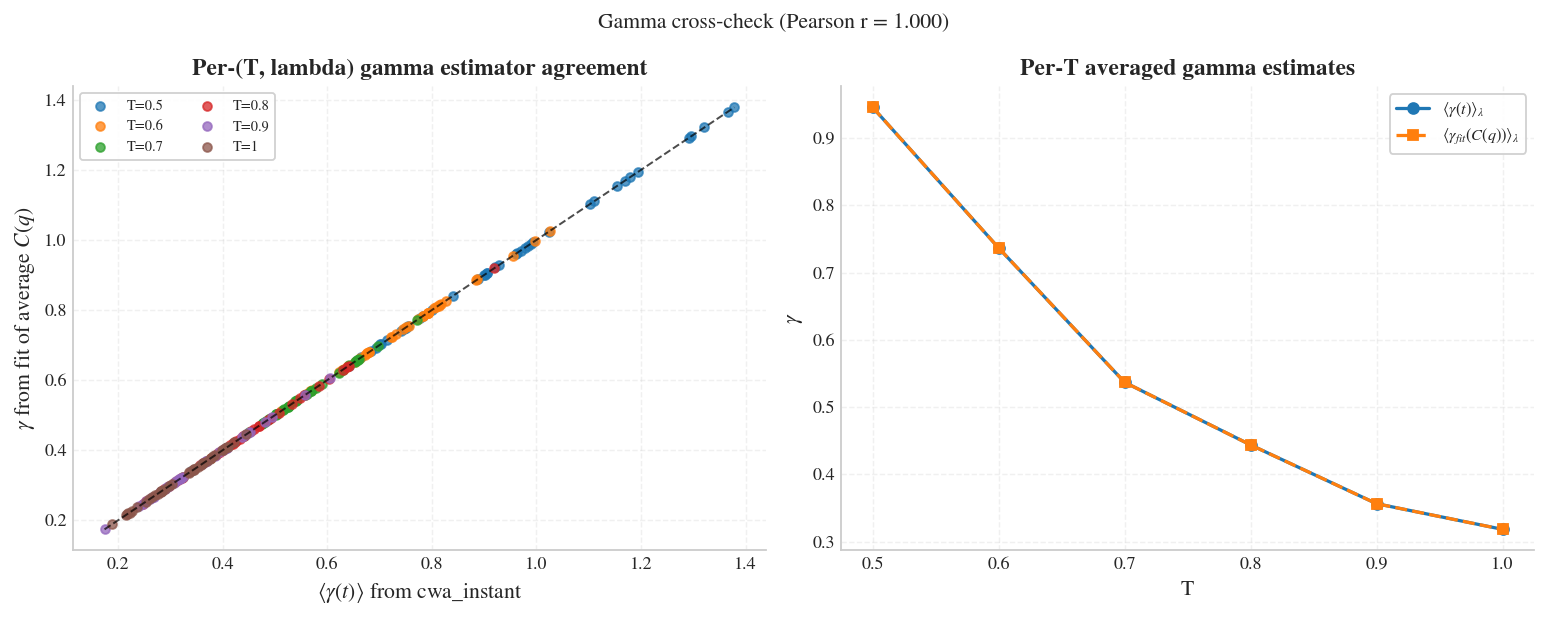

Per-T gamma comparison table:


,T,gamma_time_mean,gamma_fit_mean,n_lambda
0,0.5,0.945628,0.945628,41
1,0.6,0.736630,0.736630,41
2,0.7,0.536927,0.536927,41
3,0.8,0.443806,0.443806,41
4,0.9,0.356451,0.356451,41
5,1.0,0.318304,0.318304,41


In [5]:
# --- Gamma cross-check: <gamma(t)> vs gamma from average C(q) fit ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if 'group_stats_df' not in globals() or 'gamma_fit_df' not in globals():
    raise RuntimeError('Run the first cell first to build group_stats_df and gamma_fit_df.')

cmp = group_stats_df.merge(
    gamma_fit_df[['T', 'lambda', 'gamma_fit_from_avg_Cq', 'n_modes_fit']],
    on=['T', 'lambda'],
    how='left',
)

valid = cmp[np.isfinite(cmp['gamma_mean']) & np.isfinite(cmp['gamma_fit_from_avg_Cq'])].copy()
if valid.empty:
    raise RuntimeError('No valid points for gamma cross-check.')

fig, axes = plt.subplots(1, 2, figsize=(12, 4.8))

for T, sub in valid.groupby('T'):
    axes[0].scatter(
        sub['gamma_mean'],
        sub['gamma_fit_from_avg_Cq'],
        s=24,
        alpha=0.75,
        label=f'T={T:g}',
    )

xy_min = float(np.nanmin([valid['gamma_mean'].min(), valid['gamma_fit_from_avg_Cq'].min()]))
xy_max = float(np.nanmax([valid['gamma_mean'].max(), valid['gamma_fit_from_avg_Cq'].max()]))
axes[0].plot([xy_min, xy_max], [xy_min, xy_max], 'k--', lw=1.1, alpha=0.7)
axes[0].set_xlabel(r'$\langle \gamma(t) \rangle$ from cwa_instant')
axes[0].set_ylabel(r'$\gamma$ from fit of average $C(q)$')
axes[0].set_title('Per-(T, lambda) gamma estimator agreement')
axes[0].grid(True, alpha=0.28, ls='--')
axes[0].legend(ncol=2, fontsize=8)

corr = np.corrcoef(valid['gamma_mean'].values, valid['gamma_fit_from_avg_Cq'].values)[0, 1]

by_T = (
    valid.groupby('T')
    .agg(
        gamma_time_mean=('gamma_mean', 'mean'),
        gamma_fit_mean=('gamma_fit_from_avg_Cq', 'mean'),
        n_lambda=('lambda', 'count'),
    )
    .reset_index()
    .sort_values('T')
)

axes[1].plot(by_T['T'], by_T['gamma_time_mean'], 'o-', lw=1.8, label=r'$\langle \gamma(t) \rangle_{\lambda}$')
axes[1].plot(by_T['T'], by_T['gamma_fit_mean'], 's--', lw=1.8, label=r'$\langle \gamma_{fit}(C(q)) \rangle_{\lambda}$')
axes[1].set_xlabel('T')
axes[1].set_ylabel(r'$\gamma$')
axes[1].set_title('Per-T averaged gamma estimates')
axes[1].grid(True, alpha=0.28, ls='--')
axes[1].legend(fontsize=9)

fig.suptitle(f'Gamma cross-check (Pearson r = {corr:.3f})')
fig.tight_layout()
plt.show()

print('Per-T gamma comparison table:')
display(by_T)


In [6]:
# --- Geometric-only loader: edge lengths, network sizes, mixed-triangle stats ---
from pathlib import Path
import tarfile
import re
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if "apply_plot_style" not in globals():
    def apply_plot_style():
        plt.style.use("seaborn-v0_8-whitegrid")
        plt.rcParams.update({
            "figure.dpi": 130,
            "savefig.dpi": 300,
            "axes.titlesize": 13,
            "axes.titleweight": "semibold",
            "axes.labelsize": 12,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "grid.alpha": 0.28,
            "grid.linestyle": "--",
            "legend.frameon": True,
            "legend.framealpha": 0.9,
            "legend.fancybox": True,
            "legend.edgecolor": "0.8",
            "mathtext.fontset": "stix",
            "font.family": "STIXGeneral",
        })

apply_plot_style()


def _parse_t_label(path: Path):
    label = path.stem.split('_', 1)[1]
    return float(label), label


def _parse_kv_numeric(line: str):
    tokens = [tok.strip() for tok in line.split(',') if tok.strip() != '']
    if len(tokens) % 2 != 0:
        return {}
    out = {}
    for key, value in zip(tokens[::2], tokens[1::2]):
        try:
            out[key] = float(value)
        except ValueError:
            out[key] = np.nan
    return out


def _extract_member(tf: tarfile.TarFile, candidates):
    for name in candidates:
        try:
            f = tf.extractfile(name)
            if f is not None:
                return f
        except KeyError:
            continue
    return None


if "run_root" in globals():
    geo_run_root = Path(run_root)
else:
    candidates = [
        Path('/home/bh692/scratch_pi_co54/bh692/results/20260113_test_area_with_num_tri_types'),
        Path('../results/20260113_test_area_with_num_tri_types'),
        Path('results/20260113_test_area_with_num_tri_types'),
    ]
    geo_run_root = next((p for p in candidates if p.exists()), candidates[0])

if not geo_run_root.exists():
    raise RuntimeError(f'Cannot find run root: {geo_run_root}')

T_geo = float(globals().get('T_geo', 0.8))
lambda_geo = float(globals().get('lambda_geo', 0.5))
snapshot_stride = int(globals().get('snapshot_stride', 20))
max_snapshots = int(globals().get('max_snapshots', 300))
GEO_STEP_MIN = int(globals().get('min_step_count', 100000))

if snapshot_stride < 1:
    snapshot_stride = 1
if max_snapshots < 1:
    max_snapshots = 1

# Find tar nearest requested T
all_tar_paths = sorted(geo_run_root.glob('T_*.tar'), key=lambda p: _parse_t_label(p)[0])
if not all_tar_paths:
    raise RuntimeError(f'No T_*.tar files found in {geo_run_root}')

T_to_tar = {round(_parse_t_label(p)[0], 6): p for p in all_tar_paths}
T_key = min(T_to_tar.keys(), key=lambda t: abs(t - T_geo))
if abs(T_key - T_geo) > 1e-9:
    print(f'Using closest available T={T_key:g} for requested T_geo={T_geo:g}')
T_geo = T_key
tar_path = T_to_tar[T_geo]
_, t_label = _parse_t_label(tar_path)
lam_label = f"{lambda_geo:.6f}"

print(f'Loading geometric data from: {tar_path}')
print(f'T={T_geo:g}, lambda={lam_label}, stride={snapshot_stride}, max_snapshots={max_snapshots}')
print(f'Using only rows/snapshots with step > {GEO_STEP_MIN}')

edge_lengths = []
nodes_per_network = []
edges_per_network = []
max_cluster_fraction = []
n_networks_per_snapshot = []
snapshot_steps = []

tri_mixed_fraction = []
tri_aab = []
tri_abb = []

with tarfile.open(tar_path, 'r') as tf:
    prefix_a = f'./T_{t_label}/lambda_{lam_label}/ab_networks/csv/ab_network_snapshot_step_'
    prefix_b = f'T_{t_label}/lambda_{lam_label}/ab_networks/csv/ab_network_snapshot_step_'

    snap_members = []
    for member in tf:
        name = member.name
        if (name.startswith(prefix_a) or name.startswith(prefix_b)) and name.endswith('.csv'):
            snap_members.append(name)

    if not snap_members:
        raise RuntimeError(f'No AB network snapshots found for T={T_geo:g}, lambda={lam_label}')

    def _step_from_name(name: str):
        m = re.search(r'_step_(\d+)\.csv$', name)
        return int(m.group(1)) if m else -1

    snap_members = sorted(snap_members, key=_step_from_name)
    snap_members = [name for name in snap_members if _step_from_name(name) > GEO_STEP_MIN]
    snap_members = snap_members[::snapshot_stride]
    snap_members = snap_members[:max_snapshots]

    if not snap_members:
        raise RuntimeError(f'No AB network snapshots found with step > {GEO_STEP_MIN} for T={T_geo:g}, lambda={lam_label}')

    for member_name in snap_members:
        step_val = _step_from_name(member_name)
        f = tf.extractfile(member_name)
        if f is None:
            continue

        node_counts = defaultdict(int)
        edge_counts = defaultdict(int)
        n_nodes_total = np.nan
        n_networks = np.nan

        for raw in f:
            line = raw.decode('utf-8', 'ignore').strip()
            if not line:
                continue

            parts = [p.strip() for p in line.split(',')]
            kind = parts[0]

            if kind == 'summary':
                d = {}
                for i in range(1, len(parts) - 1, 2):
                    d[parts[i]] = parts[i + 1]
                try:
                    n_networks = float(d.get('n_networks', np.nan))
                except ValueError:
                    n_networks = np.nan
                try:
                    n_nodes_total = float(d.get('n_nodes_total', np.nan))
                except ValueError:
                    n_nodes_total = np.nan

            elif kind == 'node':
                # node,net_idx,<id>,node_idx,...
                if len(parts) >= 3:
                    try:
                        net_idx = int(float(parts[2]))
                        node_counts[net_idx] += 1
                    except ValueError:
                        pass

            elif kind == 'edge':
                # edge,net_idx,<id>,...,x0,<val>,y0,<val>,x1,<val>,y1,<val>
                kv = {}
                for i in range(1, len(parts) - 1, 2):
                    kv[parts[i]] = parts[i + 1]

                try:
                    net_idx = int(float(kv.get('net_idx', np.nan)))
                    edge_counts[net_idx] += 1
                except ValueError:
                    pass

                try:
                    x0 = float(kv.get('x0', np.nan))
                    y0 = float(kv.get('y0', np.nan))
                    x1 = float(kv.get('x1', np.nan))
                    y1 = float(kv.get('y1', np.nan))
                    if np.isfinite(x0) and np.isfinite(y0) and np.isfinite(x1) and np.isfinite(y1):
                        edge_lengths.append(float(np.hypot(x1 - x0, y1 - y0)))
                except ValueError:
                    pass

        if node_counts:
            counts = np.array(list(node_counts.values()), dtype=float)
            nodes_per_network.extend(counts.tolist())
            nmax = float(np.max(counts))
            ntot = float(n_nodes_total) if np.isfinite(n_nodes_total) and n_nodes_total > 0 else float(np.sum(counts))
            if ntot > 0:
                max_cluster_fraction.append(nmax / ntot)

        if edge_counts:
            counts = np.array(list(edge_counts.values()), dtype=float)
            edges_per_network.extend(counts.tolist())

        if np.isfinite(n_networks):
            n_networks_per_snapshot.append(float(n_networks))

        if step_val >= 0:
            snapshot_steps.append(step_val)

    tri_candidates = [
        f'./T_{t_label}/lambda_{lam_label}/sample_csv/triangulation_types_log.csv',
        f'T_{t_label}/lambda_{lam_label}/sample_csv/triangulation_types_log.csv',
    ]
    tri_file = _extract_member(tf, tri_candidates)

    if tri_file is None:
        raise RuntimeError(f'Missing triangulation_types_log.csv for T={T_geo:g}, lambda={lam_label}')

    for raw in tri_file:
        line = raw.decode('utf-8', 'ignore').strip()
        if not line or line.lower().startswith('step,aaa'):
            continue
        d = _parse_kv_numeric(line)
        step = d.get('step', np.nan)
        if not np.isfinite(step) or step <= GEO_STEP_MIN:
            continue
        aaa = d.get('AAA', np.nan)
        aab = d.get('AAB', np.nan)
        abb = d.get('ABB', np.nan)
        bbb = d.get('BBB', np.nan)
        total = aaa + aab + abb + bbb

        if np.isfinite(aab):
            tri_aab.append(float(aab))
        if np.isfinite(abb):
            tri_abb.append(float(abb))
        if np.isfinite(total) and total > 0 and np.isfinite(aab) and np.isfinite(abb):
            tri_mixed_fraction.append(float((aab + abb) / total))

geo_hist_data = {
    'T': T_geo,
    'lambda': lambda_geo,
    'edge_lengths': np.asarray(edge_lengths, dtype=float),
    'nodes_per_network': np.asarray(nodes_per_network, dtype=float),
    'edges_per_network': np.asarray(edges_per_network, dtype=float),
    'max_cluster_fraction': np.asarray(max_cluster_fraction, dtype=float),
    'n_networks_per_snapshot': np.asarray(n_networks_per_snapshot, dtype=float),
    'snapshot_steps': np.asarray(snapshot_steps, dtype=float),
    'tri_mixed_fraction': np.asarray(tri_mixed_fraction, dtype=float),
    'tri_aab': np.asarray(tri_aab, dtype=float),
    'tri_abb': np.asarray(tri_abb, dtype=float),
}

summary_rows = []
for key in [
    'edge_lengths',
    'nodes_per_network',
    'edges_per_network',
    'max_cluster_fraction',
    'tri_mixed_fraction',
    'tri_aab',
    'tri_abb',
]:
    arr = geo_hist_data[key]
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        summary_rows.append({'observable': key, 'n': 0, 'mean': np.nan, 'std': np.nan, 'p05': np.nan, 'p95': np.nan})
    else:
        summary_rows.append({
            'observable': key,
            'n': int(arr.size),
            'mean': float(np.mean(arr)),
            'std': float(np.std(arr, ddof=1)) if arr.size > 1 else np.nan,
            'p05': float(np.percentile(arr, 5)),
            'p95': float(np.percentile(arr, 95)),
        })

geo_summary_df = pd.DataFrame(summary_rows)
print('Geometric observables loaded for histogram analysis:')
print(f"snapshots used (step > {GEO_STEP_MIN}): {len(snap_members)}")
geo_summary_df


Loading geometric data from: /home/bh692/scratch_pi_co54/bh692/results/20260113_test_area_with_num_tri_types/T_0.8.tar
T=0.8, lambda=0.500000, stride=20, max_snapshots=300
Using only rows/snapshots with step > 100000


Geometric observables loaded for histogram analysis:
snapshots used (step > 100000): 200


,observable,n,mean,std,p05,p95
0,edge_lengths,256185,0.641345,0.118898,0.510848,0.880587
1,nodes_per_network,16127,15.936628,53.851793,5.000000,17.000000
2,edges_per_network,16127,15.885472,53.703348,5.000000,17.000000
3,max_cluster_fraction,200,0.294815,0.033417,0.247996,0.355153
4,tri_mixed_fraction,3999,0.012345,0.001663,0.009687,0.014707
5,tri_aab,3999,645.284321,83.717751,503.000000,757.000000
6,tri_abb,3999,636.596399,93.795109,487.000000,775.000000


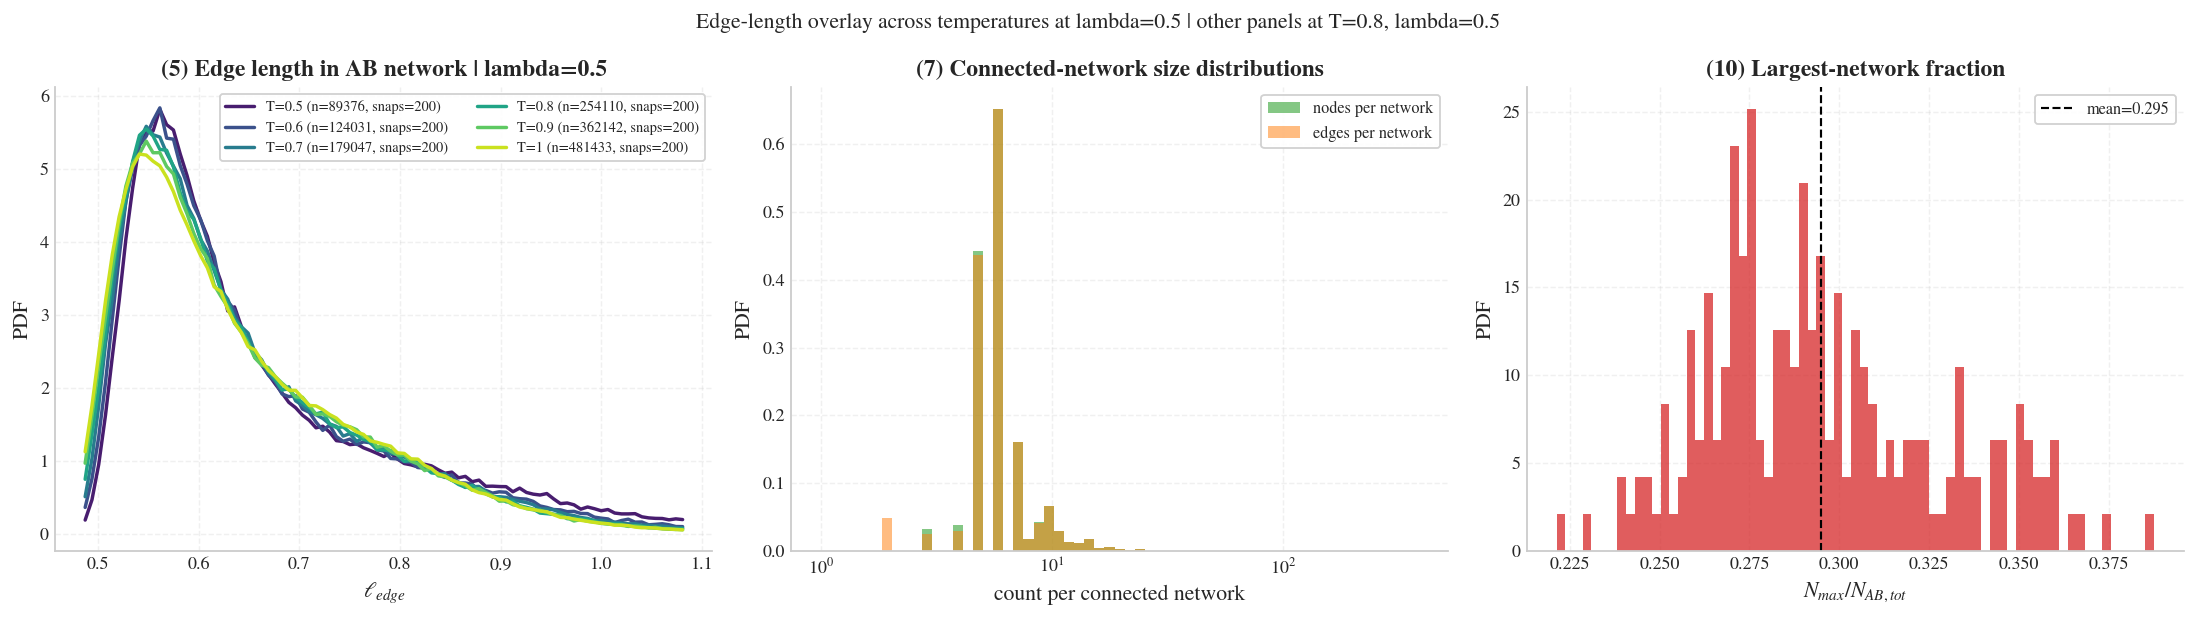

In [8]:
# --- Histograms for (5) edge lengths, (7) network sizes, (10) max cluster fraction ---
import tarfile
import re

import numpy as np
import matplotlib.pyplot as plt

if 'geo_hist_data' not in globals():
    raise RuntimeError('Run the geometric loader cell first.')

required_globals = ['geo_run_root', '_parse_t_label', 'GEO_STEP_MIN', 'snapshot_stride', 'max_snapshots']
missing = [name for name in required_globals if name not in globals()]
if missing:
    raise RuntimeError(f'Run the geometric loader cell first (missing globals: {missing}).')

T_geo = geo_hist_data['T']
lambda_geo = geo_hist_data['lambda']
lambda_overlay = float(globals().get('edge_overlay_lambda', 0.5))
lam_overlay_label = f'{lambda_overlay:.6f}'

def _step_from_name(name: str):
    m = re.search(r'_step_(\d+)\.csv$', name)
    return int(m.group(1)) if m else -1


def _load_edge_lengths_for_T(tar_path, lam_label: str):
    T_value, t_label = _parse_t_label(tar_path)
    edge_vals = []

    with tarfile.open(tar_path, 'r') as tf:
        prefix_a = f'./T_{t_label}/lambda_{lam_label}/ab_networks/csv/ab_network_snapshot_step_'
        prefix_b = f'T_{t_label}/lambda_{lam_label}/ab_networks/csv/ab_network_snapshot_step_'

        snap_members = []
        for member in tf:
            name = member.name
            if (name.startswith(prefix_a) or name.startswith(prefix_b)) and name.endswith('.csv'):
                snap_members.append(name)

        if not snap_members:
            return T_value, np.array([], dtype=float), 0

        snap_members = sorted(snap_members, key=_step_from_name)
        snap_members = [name for name in snap_members if _step_from_name(name) > GEO_STEP_MIN]
        snap_members = snap_members[::snapshot_stride]
        snap_members = snap_members[:max_snapshots]

        for member_name in snap_members:
            f = tf.extractfile(member_name)
            if f is None:
                continue

            for raw in f:
                line = raw.decode('utf-8', 'ignore').strip()
                if not line:
                    continue

                parts = [p.strip() for p in line.split(',')]
                if not parts or parts[0] != 'edge':
                    continue

                kv = {}
                for i in range(1, len(parts) - 1, 2):
                    kv[parts[i]] = parts[i + 1]

                try:
                    x0 = float(kv.get('x0', np.nan))
                    y0 = float(kv.get('y0', np.nan))
                    x1 = float(kv.get('x1', np.nan))
                    y1 = float(kv.get('y1', np.nan))
                    if np.isfinite(x0) and np.isfinite(y0) and np.isfinite(x1) and np.isfinite(y1):
                        edge_vals.append(float(np.hypot(x1 - x0, y1 - y0)))
                except ValueError:
                    continue

    return T_value, np.asarray(edge_vals, dtype=float), len(snap_members)


all_tar_paths = sorted(geo_run_root.glob('T_*.tar'), key=lambda p: _parse_t_label(p)[0])
if not all_tar_paths:
    raise RuntimeError(f'No T_*.tar files found in {geo_run_root}')

edge_lengths_by_T = {}
snapshot_count_by_T = {}
for tar_path in all_tar_paths:
    T_value, edge_vals, n_snap = _load_edge_lengths_for_T(tar_path, lam_overlay_label)
    edge_vals = edge_vals[np.isfinite(edge_vals)]
    if edge_vals.size > 1:
        edge_lengths_by_T[T_value] = edge_vals
        snapshot_count_by_T[T_value] = n_snap

if not edge_lengths_by_T:
    raise RuntimeError(f'No edge-length data found for lambda={lam_overlay_label} with step > {GEO_STEP_MIN}.')

nodes_per_network = np.asarray(geo_hist_data['nodes_per_network'], dtype=float)
nodes_per_network = nodes_per_network[np.isfinite(nodes_per_network) & (nodes_per_network > 0)]

edges_per_network = np.asarray(geo_hist_data['edges_per_network'], dtype=float)
edges_per_network = edges_per_network[np.isfinite(edges_per_network) & (edges_per_network > 0)]

max_cluster_fraction = np.asarray(geo_hist_data['max_cluster_fraction'], dtype=float)
max_cluster_fraction = max_cluster_fraction[np.isfinite(max_cluster_fraction)]

fig, axes = plt.subplots(1, 3, figsize=(17, 4.8))

# (5) edge-length distribution overlaid across all temperatures at fixed lambda
all_edge_vals = np.concatenate(list(edge_lengths_by_T.values()))
lo, hi = np.percentile(all_edge_vals, [0.5, 99.5])
if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
    lo = float(np.min(all_edge_vals))
    hi = float(np.max(all_edge_vals))
if hi <= lo:
    hi = lo + 1e-8

bins = np.linspace(lo, hi, 90)
centers = 0.5 * (bins[:-1] + bins[1:])
colors = plt.cm.viridis(np.linspace(0.08, 0.92, len(edge_lengths_by_T)))

for color, T_val in zip(colors, sorted(edge_lengths_by_T.keys())):
    arr = edge_lengths_by_T[T_val]
    sel = arr[(arr >= lo) & (arr <= hi)]
    if sel.size < 2:
        continue
    hist, _ = np.histogram(sel, bins=bins, density=True)
    axes[0].plot(
        centers,
        hist,
        lw=1.9,
        color=color,
        label=f'T={T_val:g} (n={sel.size}, snaps={snapshot_count_by_T[T_val]})',
    )

axes[0].set_title(f'(5) Edge length in AB network | lambda={lambda_overlay:g}')
axes[0].set_xlabel(r'$\ell_{edge}$')
axes[0].set_ylabel('PDF')
axes[0].grid(True, alpha=0.28, ls='--')
axes[0].legend(fontsize=8, ncol=2)

# (7) nodes/edges per connected network
vmax = 1.0
if nodes_per_network.size > 0:
    vmax = max(vmax, float(np.percentile(nodes_per_network, 99.5)))
if edges_per_network.size > 0:
    vmax = max(vmax, float(np.percentile(edges_per_network, 99.5)))
bins = np.geomspace(1.0, max(2.0, vmax), 60)

if nodes_per_network.size > 0:
    axes[1].hist(
        nodes_per_network[nodes_per_network <= bins[-1]],
        bins=bins,
        density=True,
        alpha=0.58,
        label='nodes per network',
        color='tab:green',
    )
if edges_per_network.size > 0:
    axes[1].hist(
        edges_per_network[edges_per_network <= bins[-1]],
        bins=bins,
        density=True,
        alpha=0.52,
        label='edges per network',
        color='tab:orange',
    )
axes[1].set_xscale('log')
axes[1].set_title('(7) Connected-network size distributions')
axes[1].set_xlabel('count per connected network')
axes[1].set_ylabel('PDF')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.28, ls='--')

# (10) largest-cluster fraction
if max_cluster_fraction.size > 0:
    lo, hi = np.percentile(max_cluster_fraction, [0.5, 99.5])
    lo = max(0.0, lo)
    hi = min(1.0, hi)
    if hi <= lo:
        hi = min(1.0, lo + 1e-3)
    bins = np.linspace(lo, hi, 70)
    axes[2].hist(max_cluster_fraction, bins=bins, density=True, color='tab:red', alpha=0.75)
    axes[2].axvline(np.mean(max_cluster_fraction), color='k', ls='--', lw=1.2, label=f'mean={np.mean(max_cluster_fraction):.3f}')
    axes[2].legend(fontsize=9)
axes[2].set_title('(10) Largest-network fraction')
axes[2].set_xlabel(r'$N_{max} / N_{AB,tot}$')
axes[2].set_ylabel('PDF')
axes[2].grid(True, alpha=0.28, ls='--')

fig.suptitle(
    f'Edge-length overlay across temperatures at lambda={lambda_overlay:g} | '
    f'other panels at T={T_geo:g}, lambda={lambda_geo:g}'
)
fig.tight_layout()
plt.show()


Using run root: /home/bh692/scratch_pi_co54/bh692/results/20260113_test_area_with_num_tri_types
Using only rows with step > 100000


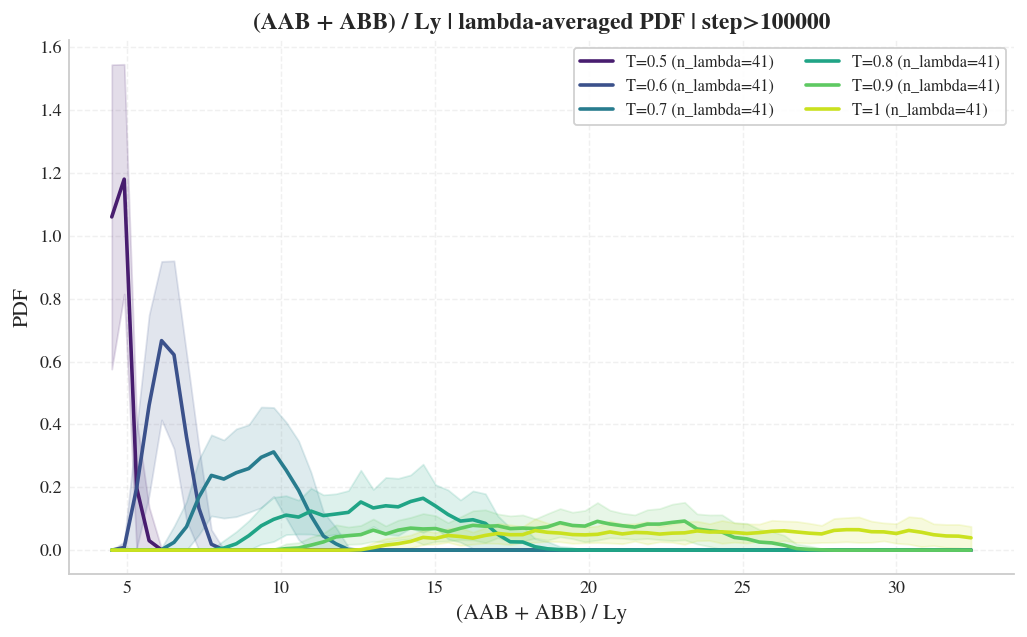

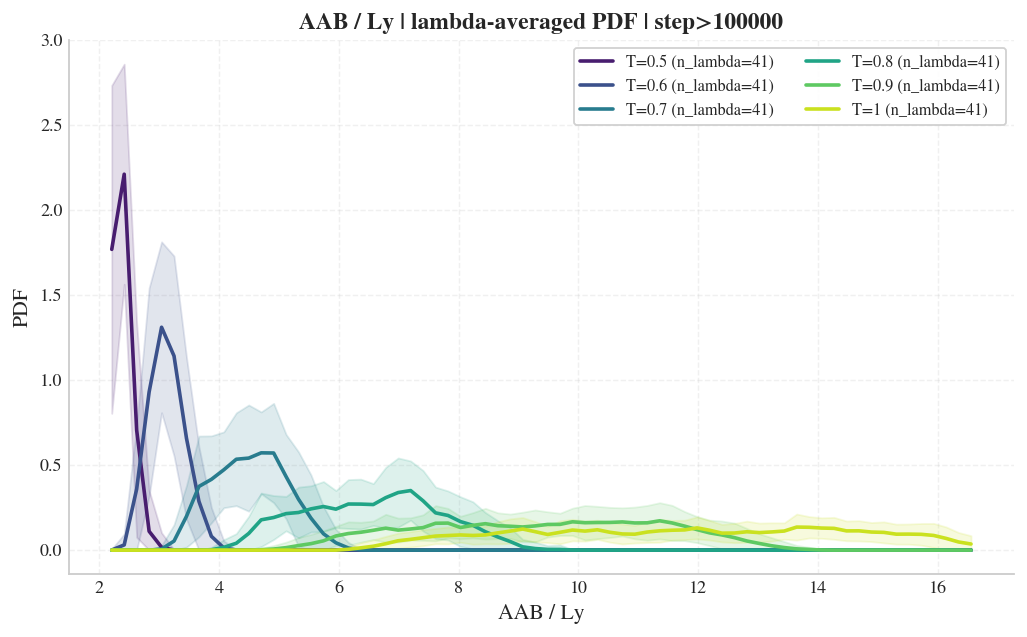

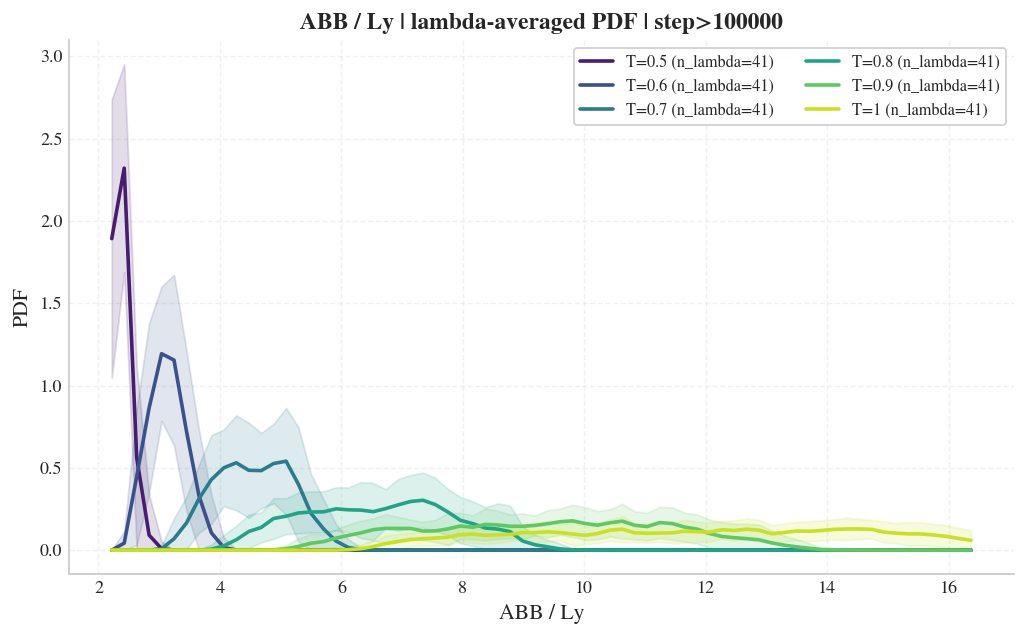

Generated figures: 3 (target: 3)


,T,metric,n_lambda_used
0,0.5,aab_over_ly,41
1,0.6,aab_over_ly,41
2,0.7,aab_over_ly,41
3,0.8,aab_over_ly,41
4,0.9,aab_over_ly,41
5,1.0,aab_over_ly,41
6,0.5,abb_over_ly,41
7,0.6,abb_over_ly,41
8,0.7,abb_over_ly,41
9,0.8,abb_over_ly,41


In [9]:
# --- Triangle count/Ly histograms: overlap all temperatures (total 3 figures) ---
from pathlib import Path
import tarfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if "run_root" in globals():
    tri_run_root = Path(run_root)
else:
    tri_candidates = [
        Path('/home/bh692/scratch_pi_co54/bh692/results/20260113_test_area_with_num_tri_types'),
        Path('../results/20260113_test_area_with_num_tri_types'),
        Path('results/20260113_test_area_with_num_tri_types'),
    ]
    tri_run_root = next((p for p in tri_candidates if p.exists()), tri_candidates[0])

if not tri_run_root.exists():
    raise RuntimeError(f'Results directory not found: {tri_run_root}')

STEP_MIN = int(globals().get('min_step_count', 100000))
lambda_values = np.round(np.arange(0.0, 1.0000001, 0.025), 6)
lambda_labels = [f'{v:.6f}' for v in lambda_values]
N_BINS = int(globals().get('triangle_hist_bins', 70))

print(f'Using run root: {tri_run_root}')
print(f'Using only rows with step > {STEP_MIN}')


def parse_t_label(path: Path):
    label = path.stem.split('_', 1)[1]
    return float(label), label


def parse_kv_numeric(line: str):
    tokens = [tok.strip() for tok in line.split(',') if tok.strip() != '']
    if len(tokens) % 2 != 0:
        return {}
    out = {}
    for key, value in zip(tokens[::2], tokens[1::2]):
        try:
            out[key] = float(value)
        except ValueError:
            out[key] = np.nan
    return out


def extract_member(tf: tarfile.TarFile, candidates):
    for name in candidates:
        try:
            f = tf.extractfile(name)
            if f is not None:
                return f
        except KeyError:
            continue
    return None


def load_ly_for_lambda(tf: tarfile.TarFile, t_label: str, lam_label: str, step_min: int):
    # Prefer Ly from cwa_instant, fallback to U_K_tot_log
    cwa_candidates = [
        f'./T_{t_label}/lambda_{lam_label}/sample_csv/cwa_instant.csv',
        f'T_{t_label}/lambda_{lam_label}/sample_csv/cwa_instant.csv',
    ]
    cwa_file = extract_member(tf, cwa_candidates)

    ly_vals = []
    if cwa_file is not None:
        for raw in cwa_file:
            line = raw.decode('utf-8', 'ignore').strip()
            if not line:
                continue
            d = parse_kv_numeric(line)
            if not d:
                continue
            step = d.get('step', np.nan)
            ly = d.get('Ly', np.nan)
            if np.isfinite(step) and step > step_min and np.isfinite(ly):
                ly_vals.append(ly)
    if ly_vals:
        return float(np.nanmedian(np.asarray(ly_vals, dtype=float)))

    u_candidates = [
        f'./T_{t_label}/lambda_{lam_label}/sample_csv/U_K_tot_log.csv',
        f'T_{t_label}/lambda_{lam_label}/sample_csv/U_K_tot_log.csv',
    ]
    u_file = extract_member(tf, u_candidates)

    ly_vals = []
    if u_file is not None:
        for raw in u_file:
            line = raw.decode('utf-8', 'ignore').strip()
            if not line:
                continue
            d = parse_kv_numeric(line)
            if not d:
                continue
            step = d.get('step', np.nan)
            ly = d.get('Ly', np.nan)
            if np.isfinite(step) and step > step_min and np.isfinite(ly):
                ly_vals.append(ly)
    if ly_vals:
        return float(np.nanmedian(np.asarray(ly_vals, dtype=float)))

    return np.nan


def load_triangle_counts_over_ly(tf: tarfile.TarFile, t_label: str, lam_label: str, ly: float, step_min: int):
    tri_candidates = [
        f'./T_{t_label}/lambda_{lam_label}/sample_csv/triangulation_types_log.csv',
        f'T_{t_label}/lambda_{lam_label}/sample_csv/triangulation_types_log.csv',
    ]
    tri_file = extract_member(tf, tri_candidates)

    if tri_file is None or (not np.isfinite(ly)) or ly <= 0:
        return {
            'mixed_over_ly': np.array([], dtype=float),
            'aab_over_ly': np.array([], dtype=float),
            'abb_over_ly': np.array([], dtype=float),
        }

    mixed_over_ly = []
    aab_over_ly = []
    abb_over_ly = []

    for raw in tri_file:
        line = raw.decode('utf-8', 'ignore').strip()
        if not line or line.lower().startswith('step,aaa'):
            continue

        d = parse_kv_numeric(line)
        if not d:
            continue

        step = d.get('step', np.nan)
        if not np.isfinite(step) or step <= step_min:
            continue

        aab = d.get('AAB', np.nan)
        abb = d.get('ABB', np.nan)

        if np.isfinite(aab):
            aab_over_ly.append(aab / ly)
        if np.isfinite(abb):
            abb_over_ly.append(abb / ly)
        if np.isfinite(aab) and np.isfinite(abb):
            mixed_over_ly.append((aab + abb) / ly)

    return {
        'mixed_over_ly': np.asarray(mixed_over_ly, dtype=float),
        'aab_over_ly': np.asarray(aab_over_ly, dtype=float),
        'abb_over_ly': np.asarray(abb_over_ly, dtype=float),
    }


def lambda_averaged_hist_with_edges(arrays_by_lambda, edges):
    valid = []
    for arr in arrays_by_lambda:
        arr = np.asarray(arr, dtype=float)
        arr = arr[np.isfinite(arr)]
        if arr.size > 1:
            valid.append(arr)

    if not valid:
        return None

    hist_list = []
    for arr in valid:
        sel = arr[(arr >= edges[0]) & (arr <= edges[-1])]
        if sel.size < 2:
            continue
        hist, _ = np.histogram(sel, bins=edges, density=True)
        hist_list.append(hist)

    if not hist_list:
        return None

    hist_mat = np.vstack(hist_list)
    centers = 0.5 * (edges[:-1] + edges[1:])

    return {
        'centers': centers,
        'mean_pdf': np.mean(hist_mat, axis=0),
        'std_pdf': np.std(hist_mat, axis=0),
        'n_lambda_used': hist_mat.shape[0],
    }


metric_specs = [
    ('mixed_over_ly', '(AAB + ABB) / Ly', 'tab:purple'),
    ('aab_over_ly', 'AAB / Ly', 'tab:cyan'),
    ('abb_over_ly', 'ABB / Ly', 'tab:pink'),
]
metric_keys = [m[0] for m in metric_specs]

# Pass 1: collect arrays per (T, lambda), grouped by metric
all_data = {}

sorted_tars = sorted(tri_run_root.glob('T_*.tar'), key=lambda p: parse_t_label(p)[0])
if not sorted_tars:
    raise RuntimeError(f'No T_*.tar files found in {tri_run_root}')

for tar_path in sorted_tars:
    T_value, t_label = parse_t_label(tar_path)
    arrays_by_metric = {k: [] for k in metric_keys}

    with tarfile.open(tar_path, 'r') as tf:
        for lam_label in lambda_labels:
            ly = load_ly_for_lambda(tf, t_label, lam_label, STEP_MIN)
            if not np.isfinite(ly) or ly <= 0:
                continue

            tri_data = load_triangle_counts_over_ly(tf, t_label, lam_label, ly, STEP_MIN)
            for key in metric_keys:
                arr = tri_data[key]
                if arr.size > 1:
                    arrays_by_metric[key].append(arr)

    all_data[T_value] = arrays_by_metric

all_T = sorted(all_data.keys())
if not all_T:
    raise RuntimeError('No temperature data could be loaded.')

# Build global edges per metric from all T and lambda data (for fair overlay)
global_edges = {}
for metric_key in metric_keys:
    pooled = []
    for T in all_T:
        pooled.extend(all_data[T][metric_key])

    pooled = [arr[np.isfinite(arr)] for arr in pooled if np.asarray(arr).size > 0]
    if not pooled:
        global_edges[metric_key] = None
        continue

    pooled_vals = np.concatenate(pooled)
    lo, hi = np.percentile(pooled_vals, [0.5, 99.5])
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo = float(np.min(pooled_vals))
        hi = float(np.max(pooled_vals))
    if hi <= lo:
        hi = lo + 1e-8

    global_edges[metric_key] = np.linspace(lo, hi, N_BINS + 1)

# Pass 2: lambda-averaged hist per (T, metric)
hist_by_T_metric = {}
summary_rows = []
for T in all_T:
    hist_by_T_metric[T] = {}
    for metric_key, metric_label, _ in metric_specs:
        edges = global_edges[metric_key]
        if edges is None:
            hist_by_T_metric[T][metric_key] = None
            summary_rows.append({'T': T, 'metric': metric_key, 'n_lambda_used': 0})
            continue

        h = lambda_averaged_hist_with_edges(all_data[T][metric_key], edges)
        hist_by_T_metric[T][metric_key] = h
        n_lam = 0 if h is None else int(h['n_lambda_used'])
        summary_rows.append({'T': T, 'metric': metric_key, 'n_lambda_used': n_lam})

# Plot: 3 figures total, each overlays all T
colors = plt.cm.viridis(np.linspace(0.08, 0.92, len(all_T)))
fig_count = 0

for metric_key, metric_label, fallback_color in metric_specs:
    fig, ax = plt.subplots(figsize=(8.0, 5.0))

    plotted_any = False
    for color, T in zip(colors, all_T):
        h = hist_by_T_metric[T].get(metric_key)
        if h is None:
            continue

        x = h['centers']
        y = h['mean_pdf']
        yerr = h['std_pdf']
        n_lambda_used = h['n_lambda_used']

        ax.plot(x, y, lw=2.0, color=color, label=f'T={T:g} (n_lambda={n_lambda_used})')
        ax.fill_between(x, np.maximum(0.0, y - yerr), y + yerr, color=color, alpha=0.15)
        plotted_any = True

    if not plotted_any:
        ax.text(0.5, 0.5, 'No valid data after filters', ha='center', va='center', transform=ax.transAxes)

    ax.set_title(f'{metric_label} | lambda-averaged PDF | step>{STEP_MIN}')
    ax.set_xlabel(metric_label)
    ax.set_ylabel('PDF')
    ax.grid(True, alpha=0.28, ls='--')
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(fontsize=9, ncol=2)

    fig.tight_layout()
    plt.show()
    fig_count += 1

summary_df = pd.DataFrame(summary_rows).sort_values(['metric', 'T']).reset_index(drop=True)
print(f'Generated figures: {fig_count} (target: 3)')
summary_df
